# Normalization of scRNA-seq data
**Author**: Adam Klie (last modified: 10/08/2023)<br>
***
**Description**: This script performs multiple normalization methods on a single scRNA-seq input dataset. The normalization methods are:

In [1]:
# Imports
import os
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import anndata2ri
import logging
from scipy.sparse import csr_matrix, issparse

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

by .GlobalEnv when processing object ‘.pbd_env’


In [7]:
# Paths
#input_h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/cellbender_dm32a/3_doublet-detection_scRNAseq.h5ad"
input_h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/dm32a/3_doublet-detection_scRNAseq.h5ad"
outdir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/cellbender_dm32a"

In [17]:
# Define run parameters
output_prefix = "4_normalization_scRNAseq"
initial_clust_n_neighbors = 30
initial_clust_resolution = 0.5
gene_markers = ["INS", "TPH1", "GCG", "ZEB2", "SST"]

In [9]:
# Read in h5ad
adata = sc.read_h5ad(input_h5ad_path)
adata

AnnData object with n_obs × n_vars = 4054 × 36601
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'at

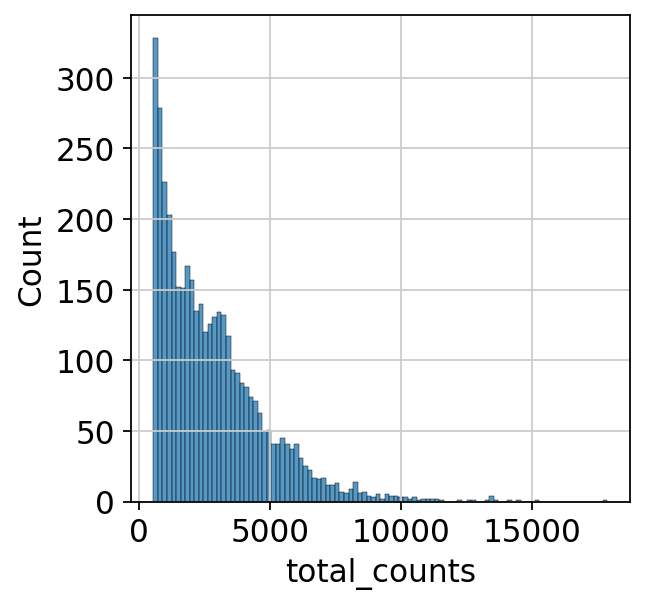

In [10]:
# Plot unnormalized total counts distribution
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

In [11]:
# Create a gene log
gene_log = dict(starting_genes=adata.n_vars)

In [12]:
# Min 20 cells - filters out 0 count genes
print(f"Total number of genes: {adata.n_vars}")
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 15708


In [13]:
# Add to gene log
gene_log["num_genes_after_cell_filter"] = adata.n_vars

# Shifted logarithm

In [14]:
# Shifted logarithm transformation
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

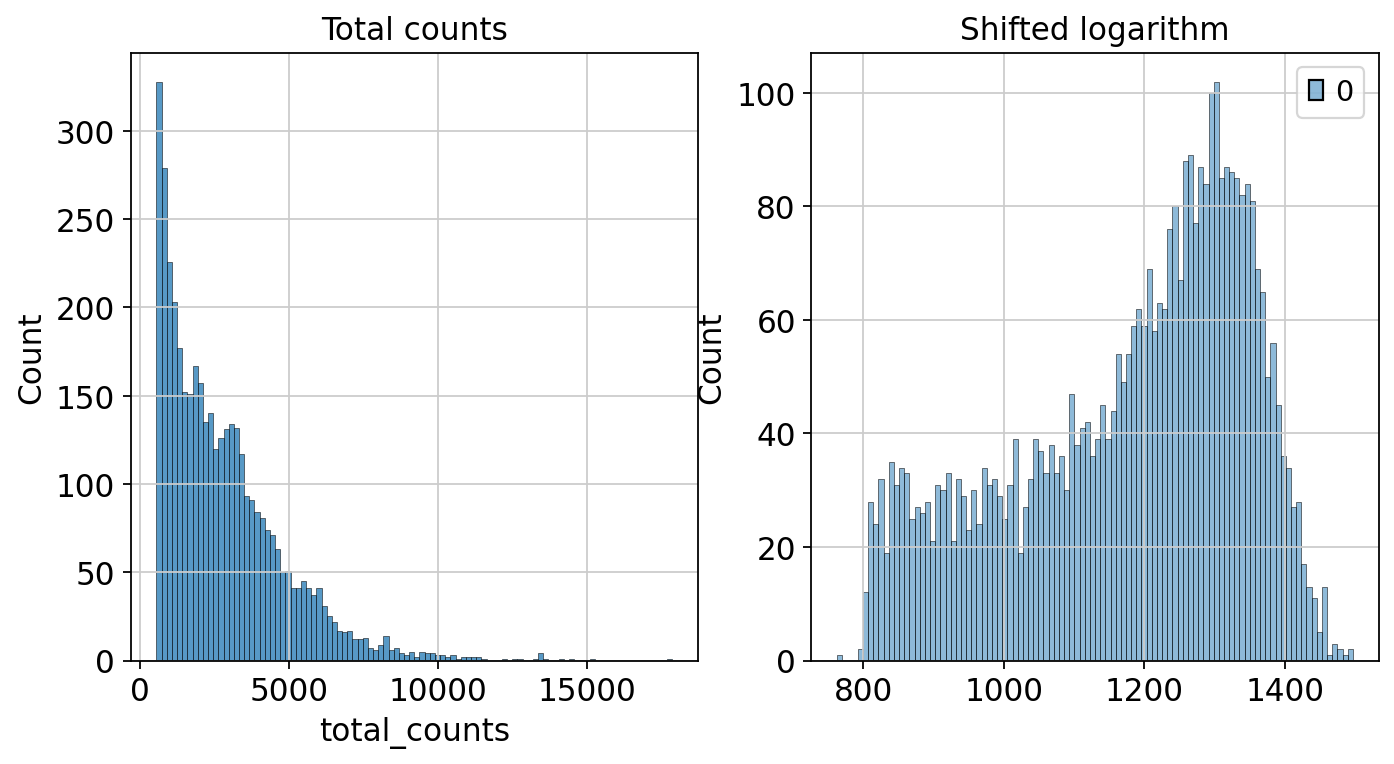

In [15]:
# Plot the side-by-side distribution of total counts before and after normalization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

# Scran normalization

In [16]:
%%R
library(scran)
library(BiocParallel)

In [18]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.filter_genes(adata_pp, min_cells=20)
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.highly_variable_genes(adata_pp, n_top_genes=3000)
adata_pp = adata_pp[:, adata_pp.var.highly_variable]
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp, n_neighbors=initial_clust_n_neighbors)
sc.tl.umap(adata_pp)
sc.tl.leiden(adata_pp, key_added="scran_groups", resolution=iniitial_clust_resolution)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


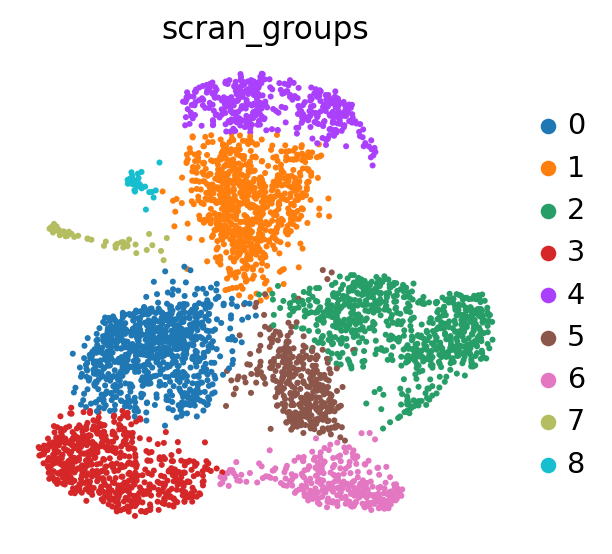

In [20]:
sc.pl.umap(adata_pp, color=["scran_groups"])

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


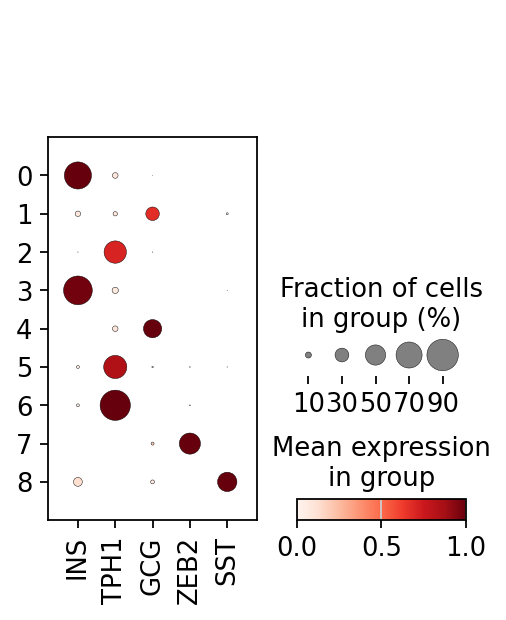

In [19]:
sc.pl.dotplot(
    adata_pp,
    groupby="scran_groups",
    var_names=gene_markers,
    standard_scale="var",
)

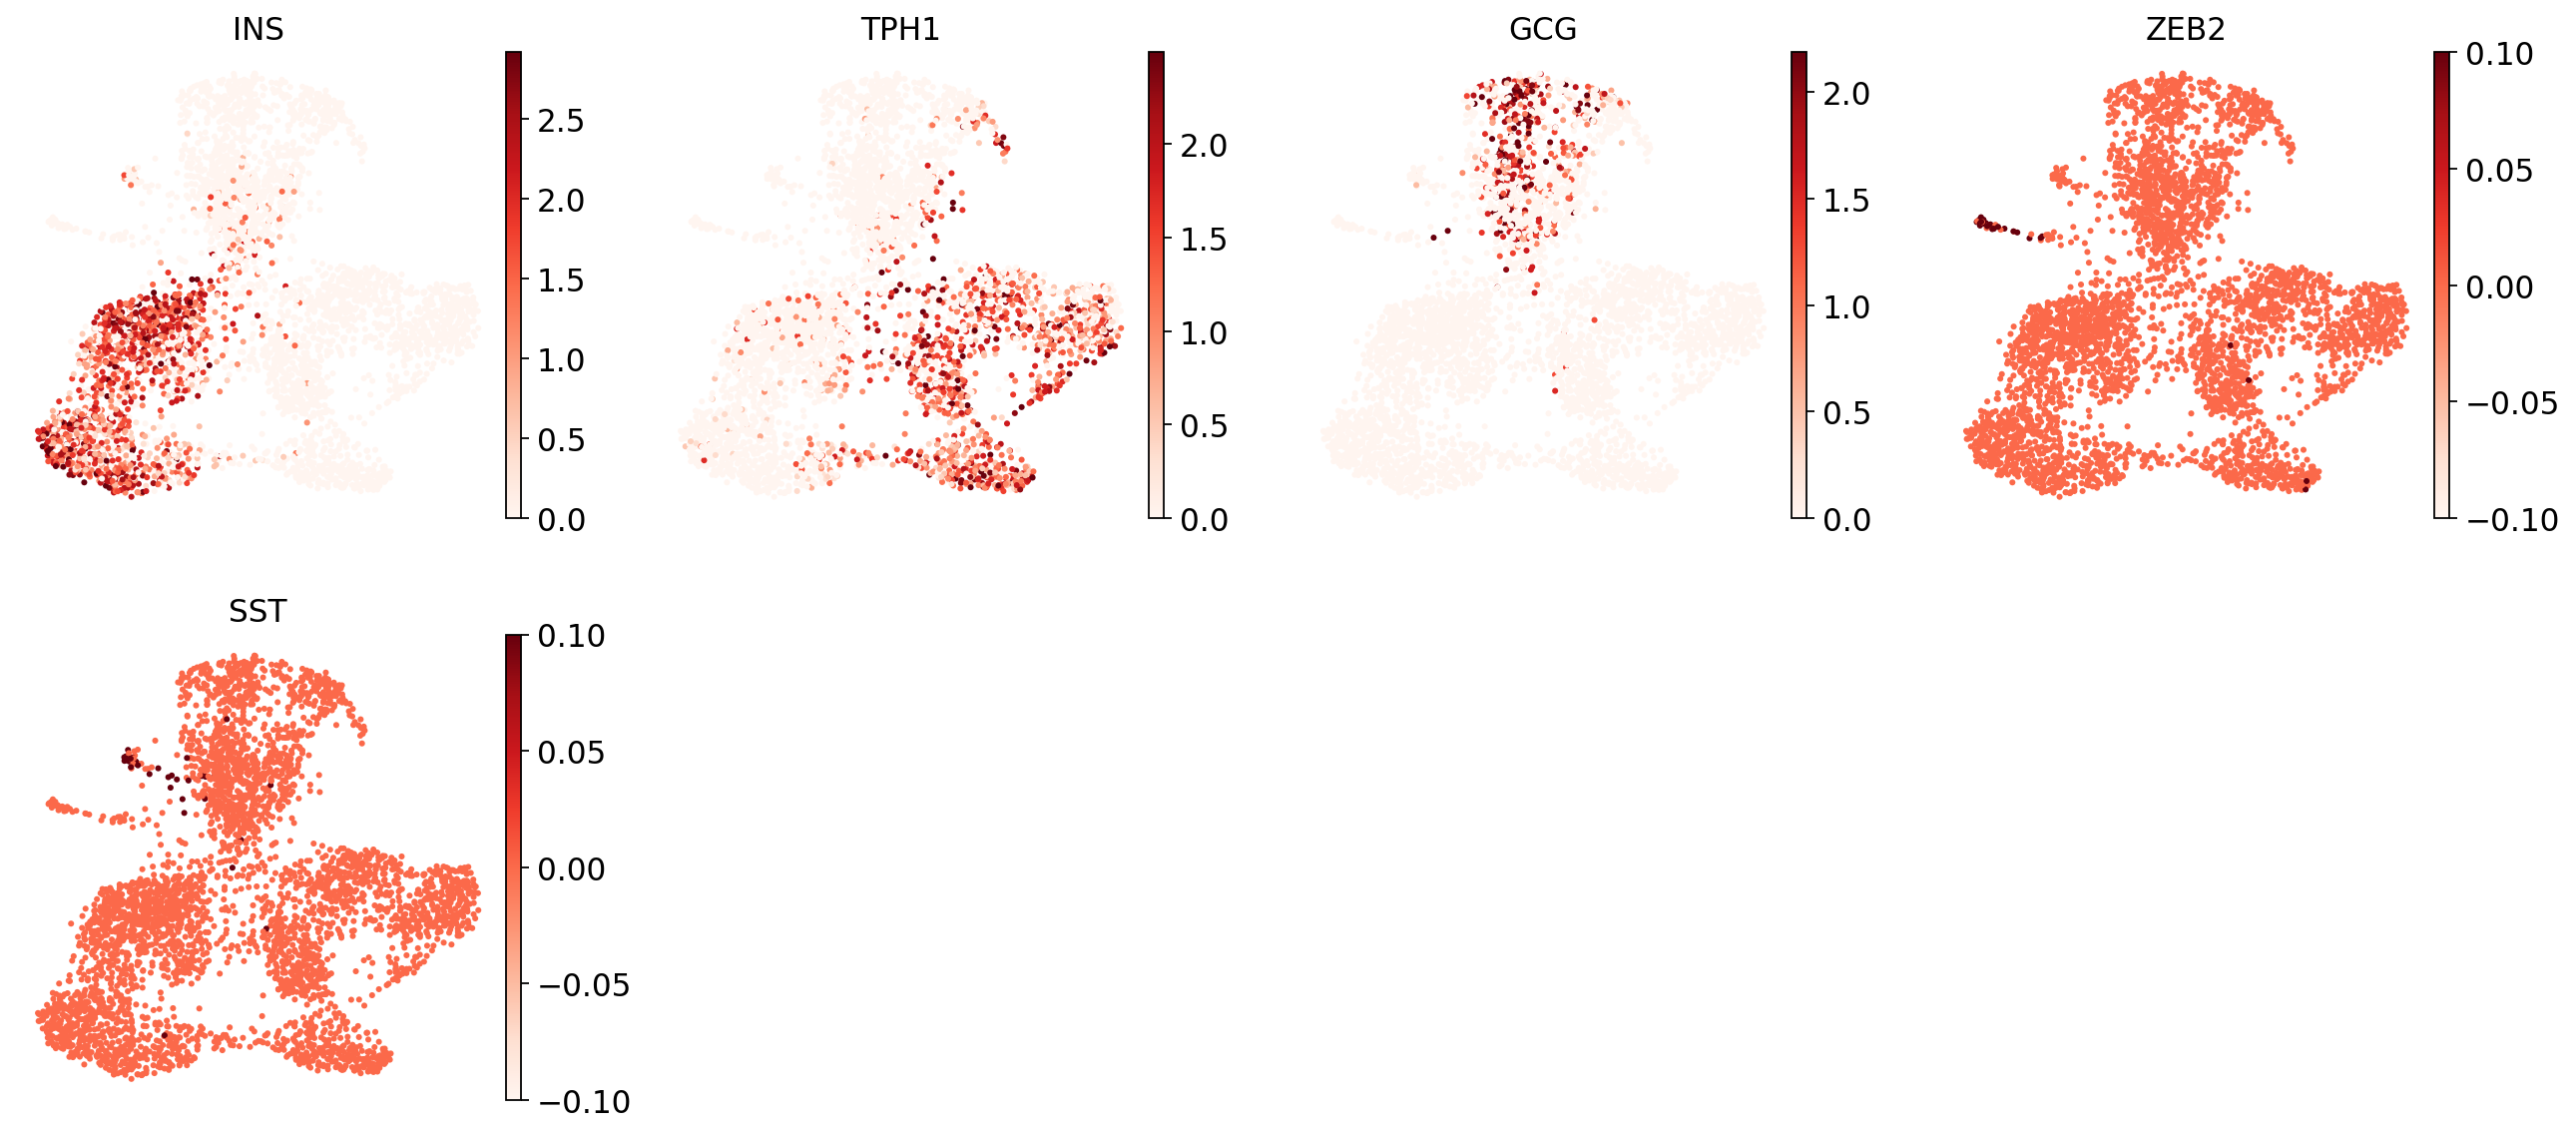

In [21]:
# Plot UMAP with covariates
sc.pl.umap(
    adata_pp,
    color=gene_markers,
    vmin=0,
    vmax="p99", 
    sort_order=False, 
    frameon=False,
    cmap="Reds", 
)

In [23]:
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
data_mat = adata_pp.X.T
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["scran_groups"]
adata.obs["scran_groups"] = adata_pp.obs["scran_groups"]

In [24]:
# Manage memory
del adata_pp

In [25]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [26]:
# Add the scran normalization to the adata object
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

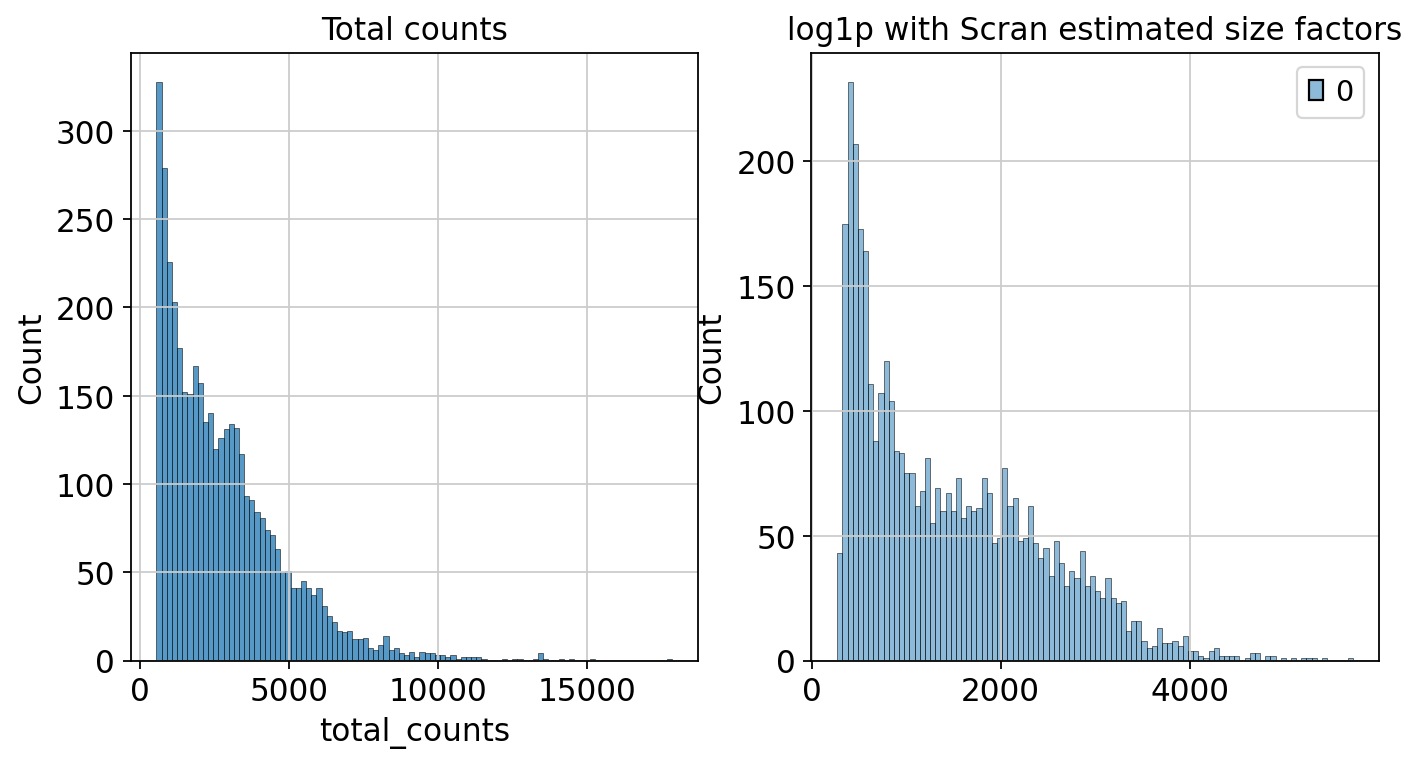

In [27]:
# Plot the side-by-side distribution of total counts before and after normalization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

# Analytical Pearson residuals

In [28]:
# Use ScanPy to normalize the data
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

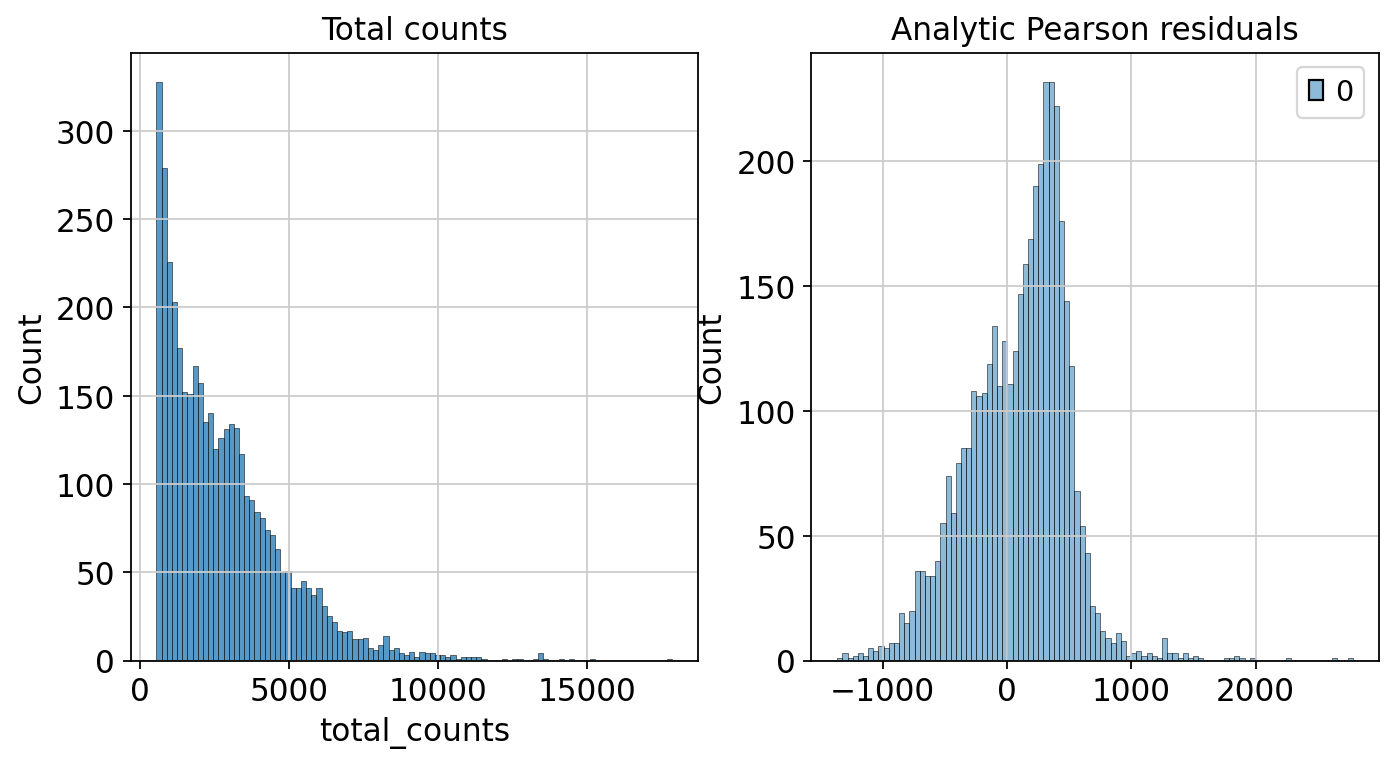

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

# SCTransform 

In [30]:
%%R
library(Seurat)
library(SeuratObject)
library(Matrix)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [31]:
# Prepare data for Seurat
data_mat = adata.X.T.astype("float32")
cell_names = adata.obs_names
gene_names = adata.var_names

In [32]:
# Load into global environment
ro.globalenv["data_mat"] = data_mat
ro.globalenv["cell_names"] = cell_names
ro.globalenv["gene_names"] = gene_names

In [33]:
%%R
mtx = Matrix(data_mat, sparse = TRUE)
rownames(mtx) = gene_names
colnames(mtx) = cell_names
sobj = CreateSeuratObject(counts = mtx, assay = "RNA")
sobj = SCTransform(sobj, verbose = FALSE, method = "glmGamPoi")
sobj

An object of class Seurat 
31416 features across 4054 samples within 2 assays 
Active assay: SCT (15708 features, 3000 variable features)
 1 other assay present: RNA


In [34]:
%%R -o counts -o data -o scale_data -o variable_genes
counts = GetAssayData(object = sobj, assay = "SCT", slot = "counts")
data = GetAssayData(object = sobj, assay = "SCT", slot = "data")
scale_data = GetAssayData(object = sobj, assay = "SCT", slot = "scale.data")
variable_genes = VariableFeatures(object = sobj)

In [39]:
# Reformat the scale data
scale_data_df = pd.DataFrame(data=scale_data.T, index=cell_names, columns=variable_genes)

In [42]:
# Add the sctransform normalization to the adata object
adata.obsm["sctransform_scale_data"] = scale_data_df
adata.layers["sctransform_corrected_counts"] = counts.T
adata.layers["sctransform_corrected_log1p_counts"] = data.T
adata.var["sctransform_genes"] = adata.var.index.isin(variable_genes)

In [ ]:
adata.layers["sctransform_corrected_counts"] = sct_counts.T
adata.layers["sctransform_corrected_log1p_counts"] = sct_data.T
adata.var["sctransform_genes"] = adata.var.index.isin(sct_variable_genes)

# pysctransform

In [99]:
from pysctransform import SCTransform

In [100]:
# Get pearson residuals for 3K highly variable genes
# https://github.com/saketkc/pySCTransform/issues/12
residuals = SCTransform(adata, var_features_n=3000, vst_flavor="v2")

In [ ]:
# Add results to AnnData obj
adata.obsm["pysctransform_pearson_residuals"] = residuals
sctgenes = residuals.columns.values
reorder_gidx = np.array([adata.var.index.get_loc(i) for i in sctgenes])
adata.var["pysctransform_genes"] = adata.var.index.isin(sctgenes)

# Depth normalization

In [43]:
import sys
sys.path.append("/cellar/users/aklie/opt/igvf-ucsd/single_cell_utilities/data_processing")
from normalizations import proportional_filtering_normalize, log1p_normalize

In [44]:
proportional_filtering_normalize(
    adata=adata,
    layer_out="depth_normalization",
)
log1p_normalize(
    adata=adata,
    layer_in="depth_normalization",
    layer_out="depth_normalization",
)
proportional_filtering_normalize(
    adata=adata,
    layer_in="depth_normalization",
    layer_out="depth_normalization",
)

# Save

In [45]:
# Save the filtered data.
adata.write(os.path.join(outdir_path, "4_normalization_scRNAseq.h5ad"))

In [ ]:
# Save gene log
gene_log.to_csv(os.path.join(outdir_path, "gene_log.csv"))

# DONE!

---

# Scratch

## Test script

```bash
input_h5ad_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/dm32a/3_doublet-detection_scRNAseq.h5ad
outdir_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/dm32a
methods="log1p scran pearson sctransform pysctransform depth"

cd /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/bin/data_annotation/scanpy

cmd="python 4_normalization_scRNAseq.py \
--input_h5ad_path $input_h5ad_path \
--outdir_path $outdir_path \
--methods $methods"

echo $cmd
```